Experiments and ideas for experiments, 14 September 2022. 

In [1]:
import numpy as np
from typing import List

import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import argparse
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from source import *

Running on: cpu


# Defining StepReLU

In [2]:
# Lambda version

stepReLU1 = lambda v : int(torch.linalg.norm(v) >=1)*v

In [3]:
# Version with a specified cutoff value

def stepReLU(v, cutoff):
    r = torch.linalg.norm(v)
    if r < cutoff:
        return torch.zeros(np.shape(v)) 
    return v

In [4]:
# Version for the eta in the definition of a radial rescaling activation

def stepReLU_eta(r):
    if r.shape == torch.Size([]):
        if r < 1:
            return 1e-6
        return r
    else:
        for i in range(len(r)):
            if r[i] < 1:
                r[i] = 1e-6
        return r

# Examples

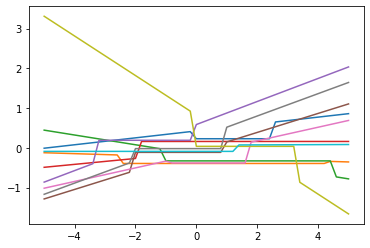

In [5]:
# Examples of stepReLU target networks
for _ in range(10):
    target_radnet = RadNet(eta=stepReLU_eta, dims=[1,2,3,1], has_bias=False)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

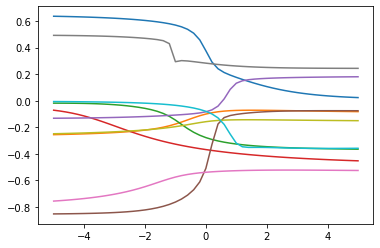

In [6]:
# Examples of sigmoid target networks
for _ in range(10):
    target_radnet = RadNet(eta=torch.sigmoid, dims=[1,2,3,1], has_bias=False)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

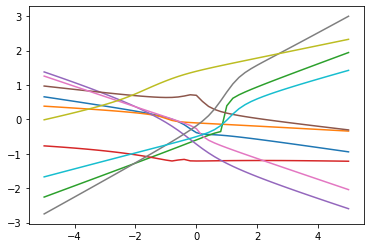

In [7]:
# Examples of ReLU target networks (with bias)
for _ in range(10):
    target_radnet = RadNet(eta=F.relu, dims=[1,2,3,1], has_bias=True)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = torch.zeros(x_target.shape)
    for i in range(x_target.shape[0]):
        y_target[i] = target_radnet(x_target[i])
    plt.plot(x_target.detach().numpy(),y_target.detach().numpy())

Next steps:

* Have a baseline MLP with several different activation functions. Try to fit each baseline to the target radial neural network (also with different activations).

* Step-ReLU networks.

* Vary parameters of the radial nn a lot. Try different input and output dimensions. 

Questions:

1. Does the radial NN converge to the target faster? Need to have the same optimizer to have a fair comparison.

2. Generalization. Train / test data split. Compare convergence over the test set. 

3. Vary the amount of train data. Is a radial nn able to fit well in a low-data regime. 

4. If you use an overparametrized radial NN to fit a reduced radial NN, is the reduction of the trained overparametrized model equal to the reduced target radial NN.

Later:

* Can we try a "natural" dataset? Maybe flow cytometry (https://en.wikipedia.org/wiki/Flow_cytometry).


# Use a radial neural network to learn another radial neural network

In [8]:
## Approximate stepReLU with stepReLU

In [9]:
def approximate(eta_target, eta_approx, dims_target, dims_approx, has_bias, n_epochs, learning_rate):
    
    # Target network
    target_radnet = RadNet(eta=eta_target, dims=dims_target, has_bias=has_bias)
    x_target = torch.tensor([-5.0 + i/5 for i in range(51)]).unsqueeze(1)
    y_target = target_radnet(x_target)
    x_target = x_target.detach()
    y_target = y_target.detach()
    plt.plot(x_target,y_target)
    
    # Approximator network, to be trained
    approx_radnet = RadNet(eta=eta_approx, dims=dims_approx, has_bias=has_bias)
    
    # Training loop
    model_trained, model_losses = training_loop(
        n_epochs = n_epochs, 
        learning_rate = learning_rate,
        model = approx_radnet,
        params = list(approx_radnet.parameters()),
        x_train = x_target,
        y_train = y_target,
        verbose=True)
    plt.plot(x_target, y_target)
    plt.plot(x_target, model_trained(x_target).detach())
    
    return model_losses[-1].detach()

Epoch 1, Loss 1.913212
Epoch 500, Loss 0.010499
Epoch 1000, Loss 0.010499
Epoch 1500, Loss 0.010499
Epoch 2000, Loss 0.010499
Epoch 2500, Loss 0.010499
Epoch 3000, Loss 0.010499
Epoch 3500, Loss 0.010499
Epoch 4000, Loss 0.010499
Epoch 4500, Loss 0.010499
Epoch 5000, Loss 0.010499


tensor(0.0105)

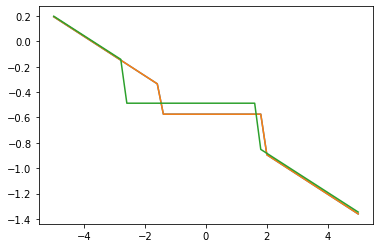

In [10]:
approximate(
    eta_target=stepReLU_eta,
    eta_approx = stepReLU_eta,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 0.040078
Epoch 500, Loss 0.000156
Epoch 1000, Loss 0.000047
Epoch 1500, Loss 0.000022
Epoch 2000, Loss 0.000014
Epoch 2500, Loss 0.000010
Epoch 3000, Loss 0.000007
Epoch 3500, Loss 0.000005
Epoch 4000, Loss 0.000004
Epoch 4500, Loss 0.000003
Epoch 5000, Loss 0.000002


tensor(2.4641e-06)

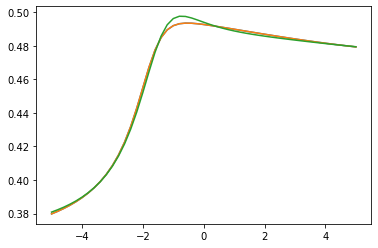

In [11]:
approximate(
    eta_target=torch.sigmoid,
    eta_approx = torch.sigmoid,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 0.714274
Epoch 500, Loss 0.000074
Epoch 1000, Loss 0.000061
Epoch 1500, Loss 0.000056
Epoch 2000, Loss 0.000052
Epoch 2500, Loss 0.000049
Epoch 3000, Loss 0.000046
Epoch 3500, Loss 0.000043
Epoch 4000, Loss 0.000040
Epoch 4500, Loss 0.000038
Epoch 5000, Loss 0.000036


tensor(3.6175e-05)

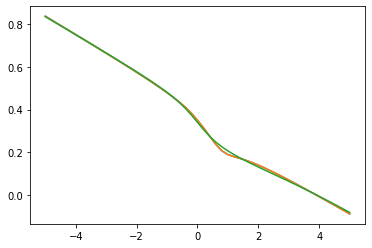

In [12]:
approximate(
    eta_target= F.relu,
    eta_approx = F.relu,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = True,
    n_epochs = 5000,
    learning_rate = 0.1)

Epoch 1, Loss 0.371711
Epoch 500, Loss 0.000103
Epoch 1000, Loss 0.000112
Epoch 1500, Loss 0.000099
Epoch 2000, Loss 0.000099
Epoch 2500, Loss 0.000099
Epoch 3000, Loss 0.000099
Epoch 3500, Loss 0.000099
Epoch 4000, Loss 0.000099
Epoch 4500, Loss 0.000099
Epoch 5000, Loss 0.000099


tensor(9.8776e-05)

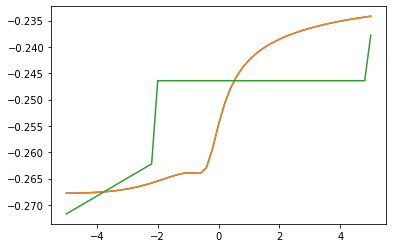

In [13]:
approximate(
    eta_target=torch.sigmoid,
    eta_approx = stepReLU_eta,
    dims_target = [1,2,3,1],
    dims_approx = [1,2,3,1],
    has_bias = False,
    n_epochs = 5000,
    learning_rate = 0.1)

# Baseline ReLU network

In [14]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 10)
    )
net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


# Use a radial neural network to learn MNIST

This page is useful: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [15]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [16]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


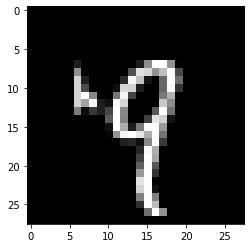

Label: 9


In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [18]:
train_features_flat = train_features.flatten(1)
train_features_flat.shape

torch.Size([64, 784])

In [19]:
radnet = RadNet(eta=torch.sigmoid, dims=[28*28,2,1], has_bias=False)

In [20]:
model_trained, model_losses = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.1,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = train_features_flat,
    y_train = train_labels,
    verbose=True)

Epoch 1, Loss 31.493786
Epoch 500, Loss 6.767394
Epoch 1000, Loss 6.767387
Epoch 1500, Loss 6.767384
Epoch 2000, Loss 6.767380
Epoch 2500, Loss 6.767379
Epoch 3000, Loss 6.767377
Epoch 3500, Loss 6.767376
Epoch 4000, Loss 6.767375
Epoch 4500, Loss 6.767374
Epoch 5000, Loss 6.767373


# Scraps

In [ ]:
x_synth = torch.tensor([-3.0 + i/20 for i in range(121)]).unsqueeze(1)
y_synth = torch.zeros(x_synth.shape)
for i in range(x_synth.shape[0]):
    y_synth[i] = torch.exp(-(x_synth[i])**2)

#################################
## Instantiate a radial neural network
#################################

radnet = RadNet(eta=torch.sigmoid, dims=[1,2,3,1], has_bias=False)
orig_dims = radnet.dims
reduce_dims = radnet.dims_red

#################################
## Train the reduced model using ordinary gradient descent
#################################

model_trained, model_losses = training_loop(
    n_epochs = 500, 
    learning_rate = 0.01,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = x_synth,
    y_train = y_synth,
    verbose=True)